# setup

In [ ]:
run_test=True
# run_test=False
epochs=(1,1,1)
epochs=(15,500,3)
cutdate='2024-06-30'
testData=''
testData='new/'
weight=0.1
itr=5
metrics_cnt=6
import torch,sys

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  mydrive='/content/drive/MyDrive/volrt/'
  source_path=mydrive+"git/Crossformer"
  tables = ['volvNVDA.csv', 'volvTSLA.csv', 'volvAAPL.csv', 'volvGOOG.csv', ]
  batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*32
  import os,sys
  if not os.path.exists(source_path):
    %cd $mydrive/git
    !git clone https://github.com/jerronl/Crossformer.git
    %cd $source_path
  else:
    %cd $source_path
    !git reset --hard HEAD
    !git pull origin master
  %pip install einops #scikit-learn
  sys.path.append( source_path)
else:
  tables = [ 'volvAAPL.csv']
  mydrive= 'E:/mydoc/git/trade/analyics/'
  batch_size=32
  sys.path.append("G:/git/Crossformer1/")
  itr=1
%cd $mydrive


E:\mydoc\git\trade\analyics


d:\ProgramData\miniconda3\envs\e1\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:


import argparse
import torch

from cross_exp.exp_crossformer import Exp_crossformer
from utils.tools import string_split
from data.data_def import set_cat
set_cat(20)

parser = argparse.ArgumentParser(description="CrossFormer")

parser.add_argument("--data", type=str, default="vols", help="data")
parser.add_argument("--weight", type=str, default=weight, help="data")
parser.add_argument(
    "--root_path", type=str, default=mydrive, help="root path of the data file"
)
parser.add_argument("--data_path", type=list, default=tables, help="data file")
parser.add_argument(
    "--data_split",
    type=str,
    default="0.7,0.1,0.2",
    help="train/val/test split, can be ratio or number",
)
parser.add_argument(
    "--checkpoints",
    type=str,
    default="./checkpoints/",
    help="location to store model checkpoints",
)

parser.add_argument("--in_len", type=int, default=20, help="input MTS length (T)")
parser.add_argument("--out_len", type=int, default=1, help="output MTS length (\tau)")
parser.add_argument("--seg_len", type=int, default=5, help="segment length (L_seg)")
parser.add_argument(
    "--win_size", type=int, default=2, help="window size for segment merge"
)
parser.add_argument(
    "--factor",
    type=int,
    default=10,
    help="num of routers in Cross-Dimension Stage of TSA (c)",
)

parser.add_argument(
    "--d_model", type=int, default=256, help="dimension of hidden states (d_model)"
)
parser.add_argument(
    "--d_ff", type=int, default=512, help="dimension of MLP in transformer"
)
parser.add_argument("--n_heads", type=int, default=4, help="num of heads")
parser.add_argument("--e_layers", type=int, default=3, help="num of encoder layers (N)")
parser.add_argument("--dropout", type=float, default=0.2, help="dropout")

parser.add_argument(
    "--baseline",
    action="store_true",
    help="whether to use mean of past series as baseline for prediction",
    default=False,
)

parser.add_argument(
    "--num_workers", type=int, default=0, help="data loader num workers"
)
parser.add_argument(
    "--batch_size", type=int, default=32, help="batch size of train input data"
)
parser.add_argument("--train_epochs", type=int, default=20, help="train epochs")
parser.add_argument("--patience", type=int, default=3, help="early stopping patience")
parser.add_argument(
    "--learning_rate", type=float, default=1e-4, help="optimizer initial learning rate"
)
parser.add_argument("--lradj", type=str, default="type1", help="adjust learning rate")
parser.add_argument("--itr", type=int, default=itr, help="experiments times")

parser.add_argument(
    "--save_pred",
    action="store_true",
    help="whether to save the predicted future MTS",
    default=False,
)

parser.add_argument("--use_gpu", type=bool, default=True, help="use gpu")
parser.add_argument("--resume", type=bool, default=True, help="resume")
parser.add_argument("--query", type=str, default=None, help="resume")
# parser.add_argument("--use_gpu", type=bool, default=False, help="use gpu")
parser.add_argument("--gpu", type=int, default=0, help="gpu")
parser.add_argument(
    "--use_multi_gpu", action="store_true", help="use multiple gpus", default=False
)
parser.add_argument(
    "--devices", type=str, default="0,1,2,3", help="device ids of multile gpus"
)

args = parser.parse_args(args=[])

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(" ", "")
    device_ids = args.devices.split(",")
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    print(args.gpu)


def update_args(itr):
    if args.data in data_parser.keys():
        data_info = data_parser[args.data]
        for k,v in data_info.items():
            args.__setattr__(k,v)
    if isinstance(args.data_split, str) :
        args.data_split = string_split(args.data_split)

    print("Args in experiment:")
    print(args)
    setting = "Crossformer_itr{}_il{}_ol{}_sl{}_win{}_fa{}_dm{}_nh{}_el{}_wt{}".format(
        itr,
        args.in_len,
        args.out_len,
        args.seg_len,
        args.win_size,
        args.factor,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.weight
    )
    return setting
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt


def regplot(dep_var, metrics, cols, itr=None, figsize=4):
    cnt = len(dep_var) - dep_var.count("_")
    figs = min(cnt, cols)
    _, axes = plt.subplots(math.ceil(cnt / figs), figs, figsize=(figsize*figs,figsize*max(1,cnt//figs)))
    j = 0

    for i, name in enumerate(dep_var):
        if name != "_":
            if itr:
                name=f'{itr}_{name}'
            axs = axes.flat[j] if figs > 1 else axes
            j = j + 1
            left, right = 999, -999
            for ii in range(len(results)):
                preds, trues, _ = results[ii]
                sns.regplot(
                    ax=axs,
                    x=trues[:, i],
                    y=preds[:, i],
                    scatter_kws={"color": f"C{ii}", "alpha": 0.3},
                    line_kws={"color": f"C{ii}", "alpha": 0.3},
                    label=labels[1][ii],
                )
                mask = ~np.isnan(trues[:, i])
                if not dep_var[i][:3] in ["dtm", "pmc"]:
                    left = min(left, max(np.min(trues[:, i][mask]), -5))
                    right = max(right, min(np.max(trues[:, i][mask]), 5))
                else:
                    left = min(left, np.min(trues[:, i][mask]))
                    right = max(right, np.max(trues[:, i][mask]))
            axs.set_title(name)
            axs.set_xlim(left=left, right=right)
            axs.legend()
    metric = []
    for ii in range(len(results)):
        _, _, m = results[ii]
        metric.append(m)

    metrics = np.append(
        metrics, np.array(metric).reshape([1, len(metric), len(m)]), axis=0
    )

    plt.show()
    return metrics
    


def plot_metric(metrics, labels, *args, **kwargs):
    a, b, c = metrics.shape
    _, axs = plt.subplots(
        nrows=math.ceil(c / 2),
        ncols=2, figsize=(16, 16), 
    )
    for i in range(c):
        ax = (
            axs[i // 2, i % 2] if c > 1 else axs
        )  # Handle the case when c=1 to avoid indexing errors
        for j in range(a):
            ax.plot(
                metrics[j, :, i], label=labels[0][j], *args, **kwargs
            )  # Plot each series in the i-th plot
        ax.set_title(labels[2][i])
        ax.legend()  # Show legend in each subplot

        # Set custom x-axis labels
        ax.set_xticks(range(b))  # Set x-tick positions for all 'b' points
        ax.set_xticklabels(labels[1])  # Set x-tick labels

    plt.tight_layout()
    plt.show()

def plot_hlc():
  global results,labels
  dep_var=data_names(data_columns(test_set),20)[0]
  labels=[[f'm{i}' for i in range(itr)],tables,["mae", "mse", "rmse", "mape", "mspe", "accr"]]
  metrics=np.empty((0,len(tables),metrics_cnt))
  n_categories=data_columns(test_set)["ycat"]
  for i in range(itr):
    setting=update_args(i)
    DatasetMTS.clear()
    exp = Exp_crossformer(args)
    print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    results = []
    for table in tables:
        results.append(exp.test(setting, 'prcs', True, data_path=[table], inverse=True))
    metrics=regplot(dep_var,metrics,4,i)
        
    rows=(len(results)+1)//4
    _, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))  # 1 row, 2 columns
    axes = axes.flatten()

    for j, result in enumerate(results):
        preds, trues, _ = result
        preds = preds[:, -n_categories:]
        trues = np.round(trues[:,0]).astype(int)
        df = pd.DataFrame(preds, columns=[f"{i}" for i in range(1, n_categories + 1)])
        df['True_Label'] = trues
        # Sum probabilities for each true category
        summed_probs = df.groupby('True_Label').mean().T
        ax = axes[j]
        for col in summed_probs.columns:
            ax.plot(summed_probs.index, summed_probs[col], label=f'Col {col}',
                    linestyle='--' if col>len(summed_probs.columns)*.67 else '-'
                    if col<len(summed_probs.columns)/3. else ':')

        # Add labels to each line
        for col in summed_probs.columns:
            icol=round(col)
            ax.text(
                x=summed_probs.index[icol-1],  # Place at the last x-coordinate
                y=summed_probs[col].iloc[icol-1],  # Place at the last y-coordinate
                s=f'{icol}',  # Label
                fontsize=8,  # Font size for labels
                verticalalignment='center',  # Align text vertically
                horizontalalignment='left'  # Align text horizontally
            )

        # Add rug plots
        ax.hist(trues,bins=range(max(trues)),density=True)
        # ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        ax.set_title(f'{tables[j]}_{i}')
        axes[j].set_xlim(0, n_categories-1)
    axes[-1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.show()
    
  print(metrics)
  plot_metric(metrics,labels)

np.set_printoptions(precision=4, suppress=True)


# train

In [3]:
if not run_test:
    from cross_exp.exp_crossformer import Exp_crossformer
    from data.data_loader import DatasetMTS
    data_parser = {
        "vols": {
            "patience":epochs[0],
            "train_epochs":epochs[1],
            'learning_rate':0.01,
            'data_split':[0.7,0.15,0.15],
            'batch_size':batch_size*2//5,
            'e_layers':5,
            'd_model':512,
            'lradj':'type2',
            "checkpoints":"./checkpoints/",
        },
        }
    for _ in range(epochs[2]):
        data_parser["vols"]["learning_rate"]=.01
        for i in range(epochs[2]):
            for ii in range(itr):
                # setting record of experiments
                setting = update_args(ii)
                DatasetMTS.clear()

                exp = Exp_crossformer(args)  # set experiments
                print(f">>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>")
                exp.train(setting, "vols")

                print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
                preds, trues,_ = exp.test(setting, 'vols', True, data_path=[tables[-1]], inverse=True)
                print(preds.shape, trues.shape)

                exp.train(setting, "prcs")
                preds, trues,_ = exp.test(setting, 'prcs', True, data_path=[tables[-1]], inverse=True)
                print(preds.shape, trues.shape)
            data_parser["vols"]["learning_rate"]/=3.

In [4]:
if not run_test:
    from google.colab import runtime
    runtime.unassign()

# test

In [ ]:
from data.data_loader import DatasetMTS
from data.data_def import data_columns, data_names
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
    },
    }
test_set='vols'
dep_var=data_names(data_columns(test_set),20)[0]
labels=[[f'm{i}' for i in range(itr)],tables,["mae", "mse", "rmse", "mape", "mspe", "accr"]]
metrics=np.empty((0,len(tables),metrics_cnt))
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  metrics=regplot(dep_var,metrics,4,i)

print(metrics)
plot_metric(metrics,labels)

## hlc

Args in experiment:
Namespace(data='vols', weight=0.03, root_path='E:/mydoc/git/trade/analyics/', data_path=['volvAAPL.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, d_model=512, d_ff=512, n_heads=4, e_layers=5, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type2', itr=1, save_pred=False, use_gpu=True, resume=True, query=None, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_itr0_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_wt0.03<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
 suc to load ./checkpoints/Crossformer_itr0_il20_ol1_sl5_win2_fa10_dm512_nh4_el5_wt0.03prcs/crossformer.pkl 
volvAAPL.csv 0       #2022-02-01 15:59:59#
3115    #2024-06-25 15:59:59#
4445    #2024-09-18 15:59:59#
6005    #2024-11-19 15:59:59#
Name: date, dtype: object
test 620
 mae:0.714, mse:0.783, rmse:0.848, mape:2.829, mspe:162.436, accr:0.1 


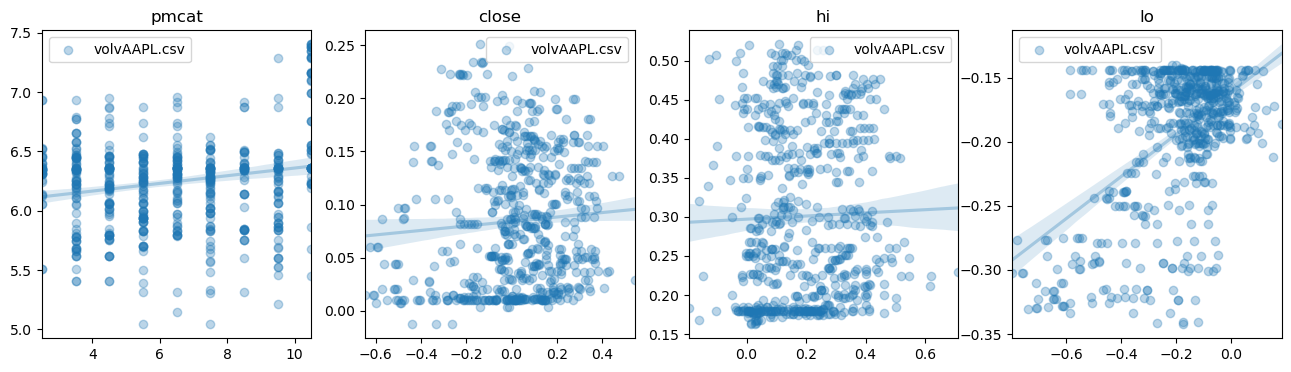

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

In [ ]:
from data.data_loader import DatasetMTS
from data.data_def import data_columns, data_names
import pandas as pd

test_set='prcs'
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
    },
    }
plot_hlc()

## horizon


In [ ]:
from data.data_loader import DatasetMTS
from cross_exp.exp_crossformer import Exp_crossformer
test_set='vols'

labels=[[f'm{i}' for i in range(itr)] ,[f'h{h+1}' for h in range(5)],["mae", "mse", "rmse", "mape", "mspe", "accr"]]
dep_var=data_names(data_columns(test_set),20)[0]
metrics=np.empty((0,len(labels[1]),len(labels[2])))
for i in range(itr):
  results = []
  for h in range(5):
    data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
        "query": f"floor(horizon)=={h+1}",
    },
    }
    setting=update_args(i)
    DatasetMTS.clear()
    exp = Exp_crossformer(args)
    print(f">>>>>>>testing : {data_parser['vols']['query']} m{i}h{h+1}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    results.append(exp.test(setting, 'vols', True, inverse=True))
  metrics=regplot(dep_var,metrics,4,i)

print(metrics)
plot_metric(metrics,labels)

## cutline

In [ ]:
from cross_exp.exp_crossformer import Exp_crossformer
from data.data_loader import DatasetMTS
from data.data_def import data_columns, data_names
test_set='vols'

data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        "query": f"date>'#{cutdate}'",
        'root_path':mydrive+testData,
    },
    }

dep_var=data_names(data_columns(test_set),20)[0]
labels=[[f'm{i}' for i in range(itr)],tables,["mae", "mse", "rmse", "mape", "mspe", "accr"]]
metrics=np.empty((0,len(tables),metrics_cnt))
for i in range(itr):
  setting=update_args(i)
  DatasetMTS.clear()
  exp = Exp_crossformer(args)
  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  results = []
  for table in tables:
      results.append(exp.test(setting, 'vols', True, data_path=[table], inverse=True))
  metrics=regplot(dep_var,metrics,4,i)

print(metrics)
plot_metric(metrics,labels)

## hlc

In [ ]:
from data.data_loader import DatasetMTS
from data.data_def import data_columns, data_names
import pandas as pd

test_set='prcs'
data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
        "query": f"date>'#{cutdate}'",
        'root_path':mydrive+testData,
        },
    }
plot_hlc()

## horizon


In [ ]:
from data.data_loader import DatasetMTS
from cross_exp.exp_crossformer import Exp_crossformer
from data.data_def import data_columns, data_names
test_set='vols'
labels=[[f'm{i}' for i in range(itr)] ,[f'h{h+1}' for h in range(5)],["mae", "mse", "rmse", "mape", "mspe", "accr"]]
dep_var=data_names(data_columns(test_set),20)[0]
metrics=np.empty((0,len(labels[1]),len(labels[2])))
for i in range(itr):
  results = []
  for h in range(5):
    data_parser = {
    "vols": {
        'e_layers':5,
        'd_model':512,
        'lradj':'type2',
        'root_path':mydrive+testData,
        "query": f"date>'#{cutdate}' and floor(horizon)=={h+1}",
    },
    }
    setting=update_args(i)
    DatasetMTS.clear()
    exp = Exp_crossformer(args)
    print(f">>>>>>>testing : {data_parser['vols']['query']} m{i}h{h+1}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    results.append(exp.test(setting, 'vols', True, inverse=True))
  metrics=regplot(dep_var,metrics,4,i)

print(metrics)
plot_metric(metrics,labels)

# end

In [ ]:
plt.show()
from google.colab import runtime
runtime.unassign()